# Airpollution Data of Switzerland
This project will have a look at air pollution data gathered from measuring stations around Switzerland.
The dataset is provided by the BFAU. Identifier code of the set is UBD0028@bundesamt-fur-umwelt-bafu.
Original dataset is provided in .ods format. The metadata and the explanation of the data fields was dropped and only the dataset itself was kept and converted into a Pandas readable .csv format.


In [1]:
#Import important libaries for the project
import pandas as pd
import numpy as np
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
#magic command for nice inline plots
%matplotlib notebook
import seaborn as sns

First load the data into an dataframe and have a first look

In [2]:
rawdata = pd.read_csv('./UBD0028.csv')
rawdata.head()

,station_id,station_name,station_measuring_network,station_canton,station_y,station_x,station_E,station_N,station_altitude,area_type_de,station_type_de,pollutant_name_de,pollutant_description_de,aggregation_name_de,limitvalue,year,value,unit_name_de,value_remark
0,agAAR,Aarau,AG,AG,646350,249400,2646350,1249400,383,Städtisch,Verkehr,NO2,Stickstoffdioxid,95%-Wert der 1/2h-Mittel,100.0,1986,80.1,µg/m3,NaN
1,agAAR,Aarau,AG,AG,646350,249400,2646350,1249400,383,Städtisch,Verkehr,NO2,Stickstoffdioxid,95%-Wert der 1/2h-Mittel,100.0,1987,51.3,µg/m3,NaN
2,agAAR,Aarau,AG,AG,646350,249400,2646350,1249400,383,Städtisch,Verkehr,NO2,Stickstoffdioxid,95%-Wert der 1/2h-Mittel,100.0,1988,49.3,µg/m3,NaN
3,agAAR,Aarau,AG,AG,646350,249400,2646350,1249400,383,Städtisch,Verkehr,NO2,Stickstoffdioxid,95%-Wert der 1/2h-Mittel,100.0,1989,58.5,µg/m3,NaN
4,agAAR,Aarau,AG,AG,646350,249400,2646350,1249400,383,Städtisch,Verkehr,NO2,Stickstoffdioxid,95%-Wert der 1/2h-Mittel,100.0,1990,82.1,µg/m3,NaN


Take a look at the different pollution types and how many entries they have

In [3]:
rawdata.pollutant_description_de.value_counts()

Ozon                                               32059
Stickstoffdioxid                                   10360
Stickoxide                                          5994
Schwefeldioxid                                      5479
Feinstaub PM10                                      4036
Kohlemonoxid                                        3075
Staubniederschlag                                    768
Blei im Staubniederschlag                            747
Cadmium im Staubniederschlag                         744
Schwebestaub insgesamt                               738
Zink im Staubniederschlag                            725
Elementarer Kohlenstoff gemessen gemäss EUSAAR2      495
Blei im Feinstaub                                    471
Cadmium im Feinstaub                                 469
Benzol                                               394
Toluol                                               393
Partikelanzahlkonzentration                          387
Thallium im Staubniederschlag  

First we will to concentrate on the Feinstaub (Particulate Matter) data. Especially on PM10 because there is more data available (PM10: 4036; PM2.5: 246; PM1: 128).
The next step is to check what aggregation types are provided by the dataset.

In [4]:
rawdata.aggregation_name_de.value_counts()

Jahresmittel                          16738
maximales Tagesmittel                  9084
95%-Wert der 1/2h-Mittel               7385
maximales Stundenmittel                2934
höchster 98%-Wert eines Monats         2929
Anzahl Stundenmittel > 120 µg/m3       2663
Anzahl Monate 98%-Wert > 100 µg/m3     2661
Anzahl Stundenmittel total             2641
Anzahl Stundenmittel > 240 µg/m3       2625
Anzahl Stundenmittel > 180 µg/m3       2612
Anzahl Tage Max. 1h > 120 µg/m3        2604
Anzahl Tage Max. 1h > 180 µg/m3        2603
Anzahl Tage Max. 1h > 240 µg/m3        2602
Dosis AOT40f                           2572
Anzahl Tagesmittel > 80 µg/m3          2426
Anzahl Tagesmittel > 50 µg/m3          1332
Anzahl Tagesmittel > 100 µg/m3         1252
Anzahl Tagesmittel > 8 mg/m3            770
Name: aggregation_name_de, dtype: int64

For a first overview it makes sense to only look at the mean values for each year (Jahresmittel).

So we will create a subset for PM10 and year means only.

In [5]:
PM10 = rawdata[(rawdata['pollutant_description_de'] == 'Feinstaub PM10') & (rawdata['aggregation_name_de'] == 'Jahresmittel')].copy()
PM10.drop(columns=['pollutant_name_de', 'pollutant_description_de', 'aggregation_name_de'], inplace=True)

In [6]:
PM10.head()

,station_id,station_name,station_measuring_network,station_canton,station_y,station_x,station_E,station_N,station_altitude,area_type_de,station_type_de,limitvalue,year,value,unit_name_de,value_remark
453,agBAD,Baden-Schönaustrasse,AG,AG,666075,257972,2666075,1257972,377,Städtisch,Hintergrund,20.0,2002,22.4,µg/m3,NaN
454,agBAD,Baden-Schönaustrasse,AG,AG,666075,257972,2666075,1257972,377,Städtisch,Hintergrund,20.0,2003,26.4,µg/m3,NaN
455,agBAD,Baden-Schönaustrasse,AG,AG,666075,257972,2666075,1257972,377,Städtisch,Hintergrund,20.0,2004,21.8,µg/m3,NaN
456,agBAD,Baden-Schönaustrasse,AG,AG,666075,257972,2666075,1257972,377,Städtisch,Hintergrund,20.0,2005,22.9,µg/m3,NaN
457,agBAD,Baden-Schönaustrasse,AG,AG,666075,257972,2666075,1257972,377,Städtisch,Hintergrund,20.0,2006,24.7,µg/m3,NaN


In [7]:
PM10.describe()

,station_y,station_x,station_E,station_N,station_altitude,limitvalue,year,value
count,1358.000000,1358.000000,1.358000e+03,1.358000e+03,1358.000000,1358.0,1358.000000,1358.000000
mean,643270.667158,191051.409426,2.643271e+06,1.191051e+06,515.388807,20.0,2007.653166,20.934315
std,73639.078000,59066.357742,7.363908e+04,5.906636e+04,342.846729,0.0,4.943874,6.130993
min,489281.000000,77455.000000,2.489281e+06,1.077455e+06,203.000000,20.0,1994.000000,1.900000
25%,593500.000000,125916.000000,2.593500e+06,1.125916e+06,377.000000,20.0,2004.000000,17.400000
50%,640730.000000,202815.000000,2.640730e+06,1.202815e+06,439.000000,20.0,2008.000000,20.600000
75%,709557.000000,247990.000000,2.709557e+06,1.247990e+06,533.000000,20.0,2012.000000,24.000000
max,801750.000000,282800.000000,2.801750e+06,1.282800e+06,3580.000000,20.0,2015.000000,50.100000


Are there non NaN values for the value_remark?

In [8]:
PM10.value_remark.value_counts()

incomplete series    53
Name: value_remark, dtype: int64

There are 53 of 1358 measurments with incomplete series or 3.9%. For this first look at the datatset we drop the data and afterwards the entire row

In [9]:
incomplete_series_index = PM10[PM10['value_remark'].notnull()].index
PM10.drop(incomplete_series_index, inplace=True)

In [10]:
PM10.value_remark.value_counts()

Series([], Name: value_remark, dtype: int64)

In [11]:
PM10.drop(columns=['value_remark'], inplace=True)

## PM10 values by area type

Now we will create a pivot table and look at the PM values distingushed by area typ Urban (Städtisch), Suburban (Vorstädisch), Rural (Ländlich), High Mountains (Hochgebirge). We will not need the station names, IDs, positions...)

In [12]:
PM10_by_area = PM10.pivot_table('value', index='year', columns='area_type_de', aggfunc='mean')

<IPython.core.display.Javascript object>


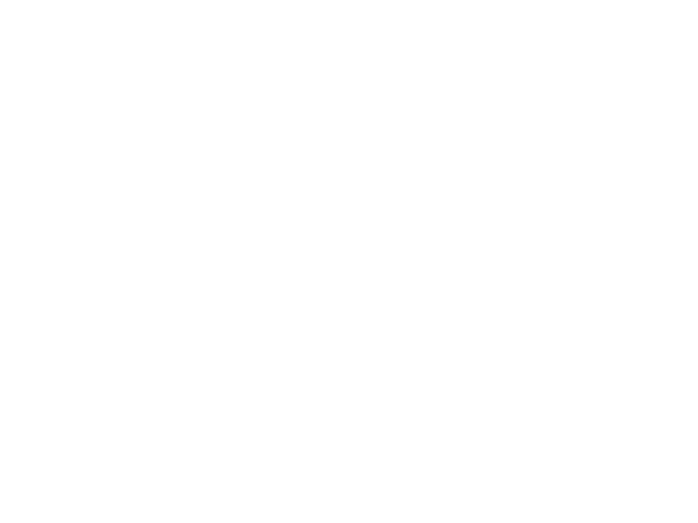

In [13]:
ax = PM10_by_area.plot(xticks=np.arange(PM10.year.min(), PM10.year.max(), step=2), grid=True)
ax.set_xlabel('Year')
ax.set_ylabel('PM10 in µ/m³')
ax.set_title('PM10 grouped by area type')
#order the legend by values
handles, labels = ax.get_legend_handles_labels()
order = [2,3,1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

The different areas show the same pattern but have different values.

What is the general correlation between the different areas? We calculate the correlations and use the seaborn pairplot tool check

In [14]:
PM10_by_area.corr()

area_type_de,Hochgebirge,Ländlich,Städtisch,Vorstädtisch
area_type_de,,,,
Hochgebirge,1.000000,0.768113,0.726168,0.666499
Ländlich,0.768113,1.000000,0.931299,0.937130
Städtisch,0.726168,0.931299,1.000000,0.928831
Vorstädtisch,0.666499,0.937130,0.928831,1.000000


<IPython.core.display.Javascript object>


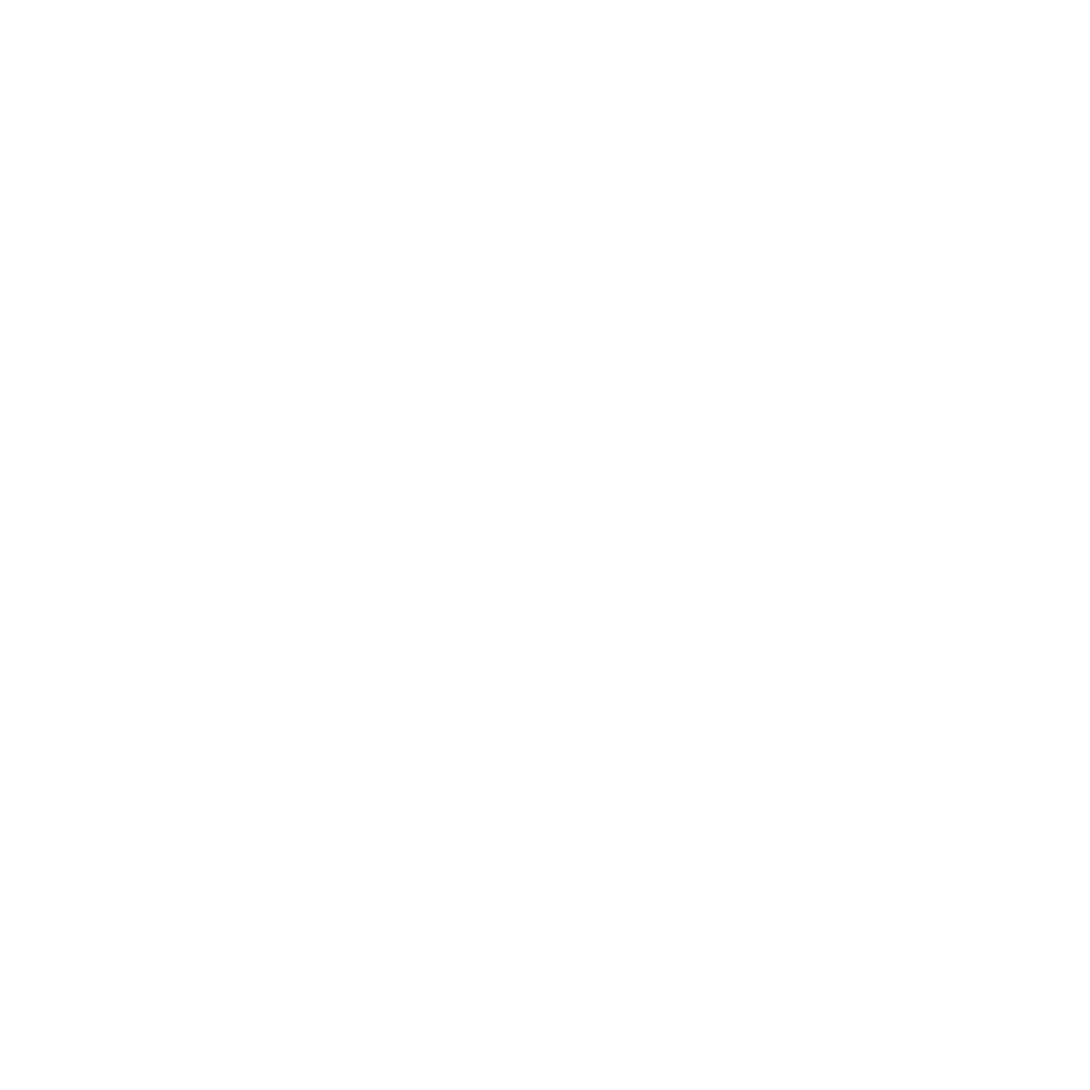

In [15]:
plt.close()
sns.pairplot(PM10_by_area, diag_kind='hist')

In [16]:
plt.close()

Indeed there is a correlation of > 0.9 between the Urban, Suburban and Rural values.

With a linear regression we could propably see how the PM pollution changes if the area type changes and if there is a linear correlation between pollution and area type (which we expect from the scatter plots and the corrleation crosstab). But be aware this is already largly aggregated data and the linear regression is mostly for the sake of training

Linear regressions will be between:
1. Urban --> Suburban: US
2. Urban --> Rural: UR
3. Suburban --> Rural: SR

In [17]:
model_US = sm.OLS(PM10_by_area['Städtisch'], sm.add_constant(PM10_by_area['Vorstädtisch']), missing='drop')

In [18]:
result_US = model_US.fit()

In [19]:
result_US.summary()

/home/clemens/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Städtisch   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     106.8
Date:                Fri, 28 Aug 2020   Prob (F-statistic):           9.51e-09
Time:                        10:28:36   Log-Likelihood:                -35.922
No. Observations:                  19   AIC:                             75.84
Df Residuals:                      17   BIC:                             77.73
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -4.5917      2.843     -1.615      0.125     -10.590       1.407
Vorstädtisch     1.3456      0.130     10.336      0.000       1.071       1.620
==============================================================================
Omnibus:                       22.375   Durbin-Watson:                   0.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.669
Skew:                           2.067   Prob(JB):                     5.95e-07
Kurtosis:                       7.374   Cond. No.                         160.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
model_UR = sm.OLS(PM10_by_area['Städtisch'], sm.add_constant(PM10_by_area['Ländlich']), missing='drop')

In [21]:
result_UR = model_UR.fit()

In [22]:
result_UR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Städtisch   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     111.1
Date:                Fri, 28 Aug 2020   Prob (F-statistic):           7.11e-09
Time:                        10:28:36   Log-Likelihood:                -35.599
No. Observations:                  19   AIC:                             75.20
Df Residuals:                      17   BIC:                             77.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7462      2.615     -1.050      0.308      -8.262       2.770
Ländlich       1.4090      0.134     10.542      0.000       1.127       1.691
==============================================================================
Omnibus:                        8.209   Durbin-Watson:                   0.928
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                5.432
Skew:                           1.178   Prob(JB):                       0.0661
Kurtosis:                       4.147   Cond. No.                         134.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
model_SR = sm.OLS(PM10_by_area['Vorstädtisch'], sm.add_constant(PM10_by_area['Ländlich']), missing='drop')

In [24]:
result_SR = model_SR.fit()

In [25]:
result_SR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Vorstädtisch   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     122.6
Date:                Fri, 28 Aug 2020   Prob (F-statistic):           3.41e-09
Time:                        10:28:37   Log-Likelihood:                -27.743
No. Observations:                  19   AIC:                             59.49
Df Residuals:                      17   BIC:                             61.37
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6958      1.729      1.559      0.137      -0.952       6.344
Ländlich       0.9787      0.088     11.072      0.000       0.792       1.165
==============================================================================
Omnibus:                        0.967   Durbin-Watson:                   1.103
Prob(Omnibus):                  0.617   Jarque-Bera (JB):                0.837
Skew:                           0.454   Prob(JB):                        0.658
Kurtosis:                       2.516   Cond. No.                         134.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>


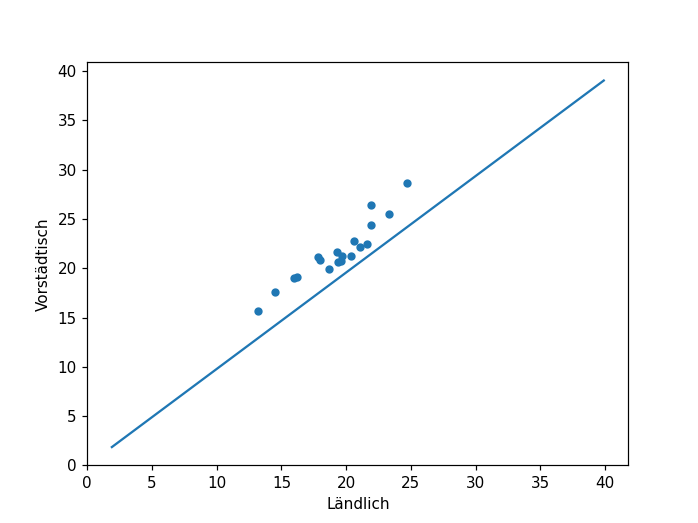

<IPython.core.display.Javascript object>


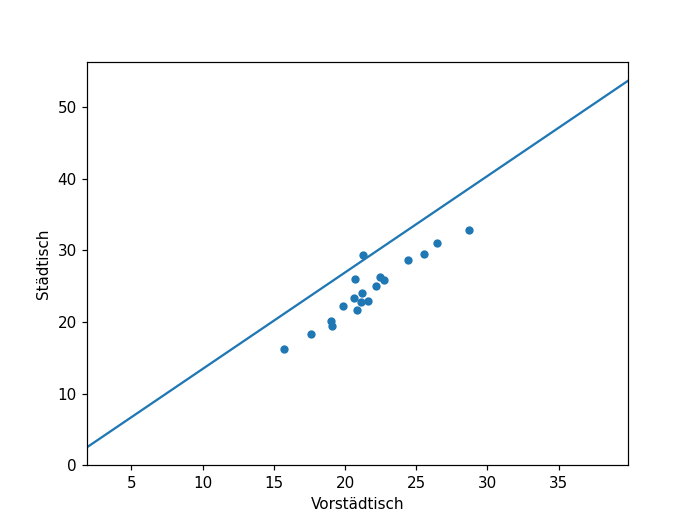

<IPython.core.display.Javascript object>


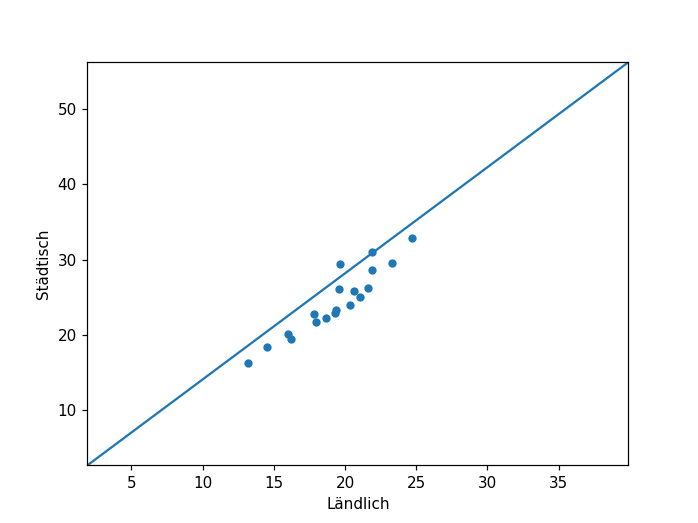

In [26]:
#x values for the calculation of the regression line
x = np.arange(PM10_by_area.min().min(), PM10_by_area.max().max())

#Suburban Rural
p = result_SR.params
ax = PM10_by_area.plot(kind='scatter', x='Ländlich', y='Vorstädtisch')
ax.plot(x, p.Ländlich * x)
plt.axis('tight')

#Urban Suburban
p = result_US.params
ax = PM10_by_area.plot(kind='scatter', x='Vorstädtisch', y='Städtisch')
ax.plot(x, p.Vorstädtisch * x)
ax.autoscale(enable=True, tight=True, axis='x')

#Urban Rural
p = result_UR.params
ax = PM10_by_area.plot(kind='scatter', x='Ländlich', y='Städtisch')
ax.plot(x, p.Ländlich * x)
ax.autoscale(enable=True, tight=True)

## PM10 by station type
We will plot the PM10 values again but this time for the different station types industry (Industrie), traffic (Verkehr) and Hintergrund (background pollution)

In [27]:
PM10_by_station = PM10.pivot_table('value', index='year', columns='station_type_de', aggfunc='mean')

<IPython.core.display.Javascript object>


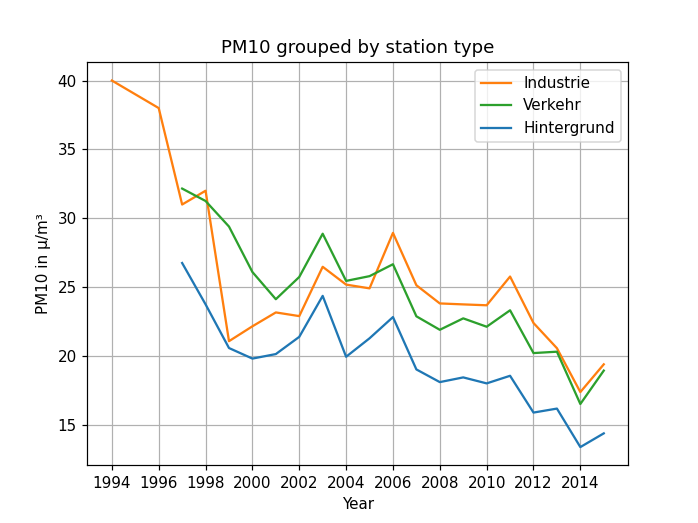

In [28]:
ax = PM10_by_station.plot(xticks=np.arange(PM10.year.min(), PM10.year.max(), step=2), grid=True)
ax.set_xlabel('Year')
ax.set_ylabel('PM10 in µ/m³')
ax.set_title('PM10 grouped by station type')
#order the legend by values
handles, labels = ax.get_legend_handles_labels()
order = [1,2,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

Shows a similar pattern to the values ordered by area types.

Out of curiosity we will plot the PM10 values ordered by area_type and the values ordered by station type in one plot

<IPython.core.display.Javascript object>


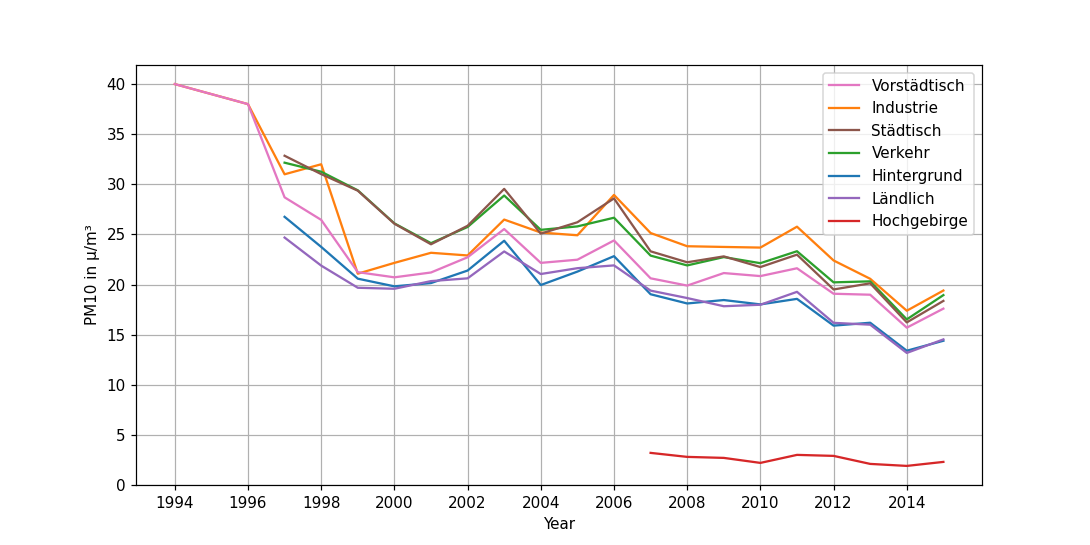

In [29]:
fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
PM10_by_station.plot(xticks=np.arange(PM10.year.min(), PM10.year.max(), step=2), grid=True, ax=ax)
PM10_by_area.plot(xticks=np.arange(PM10.year.min(), PM10.year.max(), step=2), grid=True, ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('PM10 in µ/m³')
handles, labels = ax.get_legend_handles_labels()
order = [6,1,5,2,0,4,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])